In [1]:
# Importing important libraries
import os 
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transformers
import torch.optim as optim 
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
# Path to the image files
PATH = 'F:\\Python work and projects\\CNN_classification\\dataset'

In [3]:
# creating the transformer
transform = transformers.Compose([
    transformers.Resize((224, 224)),
    transformers.ToTensor(),
    transformers.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

In [4]:
#Creating the dataset
data = torchvision.datasets.ImageFolder(root = PATH, transform = transform)

In [5]:
data.classes

['black_dress',
 'black_pants',
 'black_shirt',
 'black_shoes',
 'black_shorts',
 'blue_dress',
 'blue_pants',
 'blue_shirt',
 'blue_shoes',
 'blue_shorts']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: (tensor([[[-0.9686, -0.9216, -0.9765,  ..., -0.9922, -1.0000, -1.0000],
         [-0.9765, -0.9294, -0.9608,  ..., -0.9922, -1.0000, -0.9922],
         [-0.9686, -0.9216, -0.9529,  ..., -0.9922, -1.0000, -0.9843],
         ...,
         [ 0.1608,  0.1608,  0.1373,  ...,  0.2549,  0.2235,  0.2235],
         [ 0.0431,  0.0510,  0.1216,  ...,  0.2784,  0.2549,  0.2314],
         [ 0.1373,  0.0588,  0.1059,  ...,  0.2941,  0.2392,  0.2471]],

        [[-0.9843, -0.9373, -0.9843,  ..., -0.9922, -1.0000, -1.0000],
         [-0.9922, -0.9451, -0.9765,  ..., -0.9922, -1.0000, -0.9922],
         [-0.9843, -0.9373, -0.9686,  ..., -0.9922, -1.0000, -0.9843],
         ...,
         [-0.7020, -0.7020, -0.7333,  ..., -0.6314, -0.6627, -0.6627],
         [-0.7333, -0.7490, -0.7255,  ..., -0.6078, -0.6235, -0.6392],
         [-0.6314, -0.7333, -0.7412,  ..., -0.5922, -0.6314, -0.6157]],

        [[-0.9765, -0.9294, -0.9843,  ..., -0.9922, -1.0000, -1.0000],
         [-0.9843, -0.9373, -0.9686, 

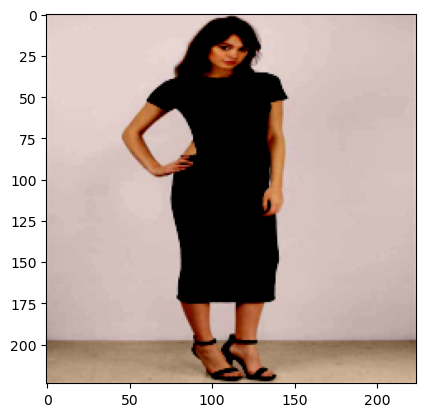

In [6]:
#Display a sample image
def display_img(img, label):
    print(f'label: {data[label]}')
    plt.imshow(img.permute(1,2,0))

display_img(*data[100])

In [7]:
# checking shape of images 
image, label = data[1563]
print('shape:', image.shape, 'label:', label)

shape: torch.Size([3, 224, 224]) label: 2


In [8]:
# Creating a list of indices
dataset_size = len(data)
indices = list(range(dataset_size))

# Shuffle the indices
np.random.shuffle(indices)

# Creating split indices
val_split_index = int(np.floor(0.2 * dataset_size))
test_split_index = int(np.floor(0.1 * dataset_size))

# Ensure correct indices for train, validation, and test
test_idx = indices[:test_split_index]
val_idx = indices[test_split_index:test_split_index + val_split_index]
train_idx = indices[test_split_index + val_split_index:]

print(len(train_idx), len(val_idx), len(test_idx))

# Data samplers
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Data loaders with custom samplers specified
train_loader = DataLoader(dataset=data, batch_size=100, sampler=train_sampler)
val_loader = DataLoader(dataset=data, batch_size=100, sampler=val_sampler)
test_loader = DataLoader(dataset=data, batch_size=100, sampler=test_sampler)

4196 1198 599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


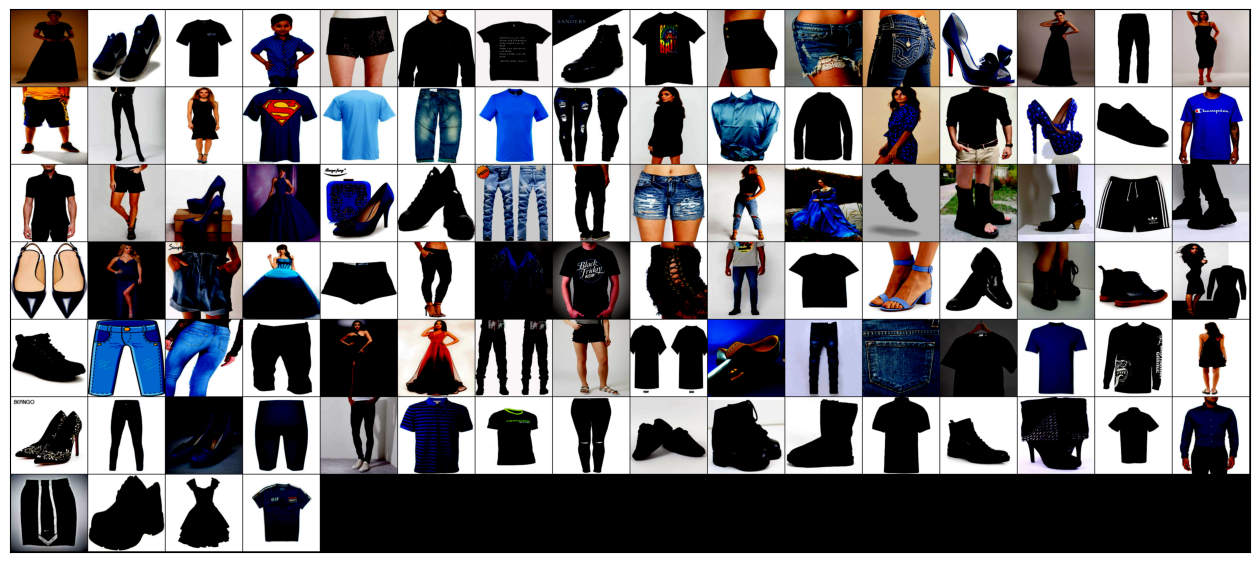

In [9]:
#plot images grid of single batch
def show_batch(dl):
    for images, label in dl:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

show_batch(train_loader)

In [10]:
#using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
#Creating a model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=4, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride = 2, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features = 128 * 3 * 3, out_features = 1200),
            nn.ReLU(),
            nn.Linear(in_features = 1200, out_features = 10),
            nn.ReLU(),
        )

    def forward(self, X):
        X = self.conv(X)
        X = torch.flatten(X, 1)
        X = self.fc(X)

        return X

model = CNN().to(device)

In [12]:
#creating loss and optimer metrics
creterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [13]:
# Training loop
losses_list = []
accuracy_list = []
epochs = 30

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = creterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    losses_list.append(epoch_loss / len(train_loader))

    # Validation loop
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader: 
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    accuracy_list.append(accuracy)

    print('Epoch: [{}/{}] Training Loss: {:.4f} Validation Accuracy: {:.4f}'.format(epoch+1, epochs, losses_list[-1], accuracy))

Epoch: [1/30] Training Loss: 2.2936 Validation Accuracy: 0.1553
Epoch: [2/30] Training Loss: 2.2767 Validation Accuracy: 0.1544
Epoch: [3/30] Training Loss: 2.2586 Validation Accuracy: 0.1544
Epoch: [4/30] Training Loss: 2.2357 Validation Accuracy: 0.1536
Epoch: [5/30] Training Loss: 2.2029 Validation Accuracy: 0.2579
Epoch: [6/30] Training Loss: 2.1261 Validation Accuracy: 0.3497
Epoch: [7/30] Training Loss: 1.9692 Validation Accuracy: 0.4015
Epoch: [8/30] Training Loss: 1.7791 Validation Accuracy: 0.4574
Epoch: [9/30] Training Loss: 1.5994 Validation Accuracy: 0.5217
Epoch: [10/30] Training Loss: 1.4481 Validation Accuracy: 0.5409
Epoch: [11/30] Training Loss: 1.3214 Validation Accuracy: 0.5793
Epoch: [12/30] Training Loss: 1.2550 Validation Accuracy: 0.6119
Epoch: [13/30] Training Loss: 1.2044 Validation Accuracy: 0.6043
Epoch: [14/30] Training Loss: 1.1049 Validation Accuracy: 0.6285
Epoch: [15/30] Training Loss: 1.0995 Validation Accuracy: 0.6035
Epoch: [16/30] Training Loss: 0.99

In [14]:
# Saving the state of the model
save_state = {
    'model' : model.state_dict(),
    'optimizer' : optimizer.state_dict()
}
torch.save(save_state, 'CNN_Black_clothes.pth')

In [22]:
# Checking the accuracy with the test dataset
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy: {:.4f}'.format(correct/total))


Test Accuracy: 0.8097


In [34]:
# Checking for precision, recall and accuracy test dataset
y_pred = predicted.to('cpu')
y_pred = y_pred.numpy()

y_true = labels.to('cpu')
y_true = y_true.numpy()

print(classification_report(y_true, y_pred, target_names = data.classes))


              precision    recall  f1-score   support

 black_dress       1.00      0.83      0.91         6
 black_pants       1.00      0.93      0.97        15
 black_shirt       0.92      0.80      0.86        15
 black_shoes       0.80      0.89      0.84         9
black_shorts       0.50      1.00      0.67         3
  blue_dress       0.80      0.89      0.84         9
  blue_pants       0.80      0.80      0.80        10
  blue_shirt       1.00      0.81      0.90        16
  blue_shoes       0.93      0.93      0.93        14
 blue_shorts       0.25      0.50      0.33         2

    accuracy                           0.86        99
   macro avg       0.80      0.84      0.80        99
weighted avg       0.89      0.86      0.87        99

